# Model 2 (CNN)

This model will be using the satellite images that we scraped using Google's Static Maps API. The images are labeled as safe or danger where safe images are those where there were no accidents and danger images were those with accidents.

In [9]:
# Importing libraries
import os, shutil
from keras import models, layers, optimizers, regularizers
import datetime
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import itertools
from sklearn.metrics import confusion_matrix, classification_report
np.random.seed(123)
from keras.applications import VGG19
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
% matplotlib inline

## Put Images into Train/Test Folders

In [2]:
data_danger_dir = 'model2_Images/danger/'
data_safe_dir = 'model2_Images/safe/'
new_dir = 'model2_split/'

In [5]:
imgs_danger = [file for file in os.listdir(data_danger_dir) if file.endswith('.jpg')]

In [4]:
print('There are',len(imgs_danger), 'danger images')

There are 5000 danger images


In [5]:
imgs_safe = [file for file in os.listdir(data_safe_dir) if file.endswith('.jpg')]

In [6]:
print('There are',len(imgs_safe), 'safe images')

There are 5000 safe images


In [7]:
os.mkdir(new_dir)

In [3]:
train_folder = os.path.join(new_dir, 'train')
train_danger = os.path.join(train_folder, 'danger')
train_safe = os.path.join(train_folder, 'safe')

val_folder = os.path.join(new_dir, 'validation')
val_danger = os.path.join(val_folder, 'danger')
val_safe = os.path.join(val_folder, 'safe')

test_folder = os.path.join(new_dir, 'test')
test_danger = os.path.join(test_folder, 'danger')
test_safe = os.path.join(test_folder, 'safe')

In [9]:
train_danger

'model2_split/train\\danger'

In [10]:
os.mkdir(train_folder)
os.mkdir(train_danger)
os.mkdir(train_safe)

os.mkdir(val_folder)
os.mkdir(val_danger)
os.mkdir(val_safe)

os.mkdir(test_folder)
os.mkdir(test_danger)
os.mkdir(test_safe)

In [11]:
# train safe
imgs = imgs_safe[:3000]
for img in imgs:
    origin = os.path.join(data_safe_dir, img)
    destination = os.path.join(train_safe, img)
    shutil.copyfile(origin, destination)
    
# validation safe
imgs = imgs_safe[3000:4000]
for img in imgs:
    origin = os.path.join(data_safe_dir, img)
    destination = os.path.join(val_safe, img)
    shutil.copyfile(origin, destination)
    
# test safe
imgs = imgs_safe[4000:]
for img in imgs:
    origin = os.path.join(data_safe_dir, img)
    destination = os.path.join(test_safe, img)
    shutil.copyfile(origin, destination)

In [12]:
# train danger
imgs = imgs_danger[:3000]
for img in imgs:
    origin = os.path.join(data_danger_dir, img)
    destination = os.path.join(train_danger, img)
    shutil.copyfile(origin, destination)
    
# validation danger
imgs = imgs_danger[3000:4000]
for img in imgs:
    origin = os.path.join(data_danger_dir, img)
    destination = os.path.join(val_danger, img)
    shutil.copyfile(origin, destination)
    
# test danger
imgs = imgs_danger[4000:]
for img in imgs:
    origin = os.path.join(data_danger_dir, img)
    destination = os.path.join(test_danger, img)
    shutil.copyfile(origin, destination)

## Model iteration 1: baseline CNN

In [142]:
 # get all the data in the directory model2_split/train (6000 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size=6000, class_mode='binary')

 # get all the data in the directory model2_split/val (2000 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size=2000, class_mode='binary')

# get all the data in the directory model2_split/test (2000 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 2000, class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [143]:
# Check labels
train_generator.class_indices

{'danger': 0, 'safe': 1}

In [144]:
# create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [145]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_val = val_images.shape[0]
m_test = test_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 6000
Number of validation samples: 2000
Number of testing samples: 2000
train_images shape: (6000, 64, 64, 3)
train_labels shape: (6000,)
val_images shape: (2000, 64, 64, 3)
val_labels shape: (2000,)
test_images shape: (2000, 64, 64, 3)
test_labels shape: (2000,)


In [147]:
np.random.seed(123)

# Construct baseline CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [148]:
history = model.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Train on 6000 samples, validate on 2000 samples
Epoch 1/10
6000/6000 [==============================] - 126s 21ms/step - loss: 0.6854 - acc: 0.5608 - val_loss: 0.6748 - val_acc: 0.6090
Epoch 2/10
6000/6000 [==============================] - 120s 20ms/step - loss: 0.6595 - acc: 0.6838 - val_loss: 0.6410 - val_acc: 0.7010
Epoch 3/10
6000/6000 [==============================] - 118s 20ms/step - loss: 0.6237 - acc: 0.6993 - val_loss: 0.6059 - val_acc: 0.6795
Epoch 4/10
6000/6000 [==============================] - 133s 22ms/step - loss: 0.5981 - acc: 0.6938 - val_loss: 0.6145 - val_acc: 0.6890
Epoch 5/10
6000/6000 [==============================] - 106s 18ms/step - loss: 0.5868 - acc: 0.6988 - val_loss: 0.5804 - val_acc: 0.7175
Epoch 6/10
6000/6000 [==============================] - 107s 18ms/step - loss: 0.5775 - acc: 0.7012 - val_loss: 0.5997 - val_acc: 0.6900
Epoch 7/10
6000/6000 [==============================] - 122s 20ms/step - loss: 0.5654 - acc: 0.7142 - val_loss: 0.6062 - val_acc: 

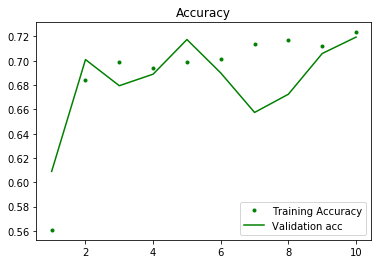

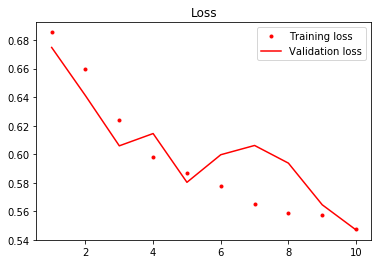

In [151]:
# Graph loss, accuracy for training and validation history
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

In [150]:
results_test = model.evaluate(test_images, test_labels)
print('Test Loss:', results_test[0])
print('Test Accuracy:', results_test[1])

2000/2000 [==============================] - 11s 6ms/step
Test Loss: 0.5429405093193054
Test Accuracy: 0.72


Pretty decent results with both train and test accuracy around 72%, much better than random chance would be, and also not much overfitting.  It also seems like loss and accuracy could possibly keep trending in their respective directions with more epochs.

In [152]:
# Get predictions for confusion matrix
# Need to round predictions to whole numbers
predictions = model.predict(test_images)
predictions = np.round(predictions)

In [16]:
# Function for plotting easier to read confusion matrix
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

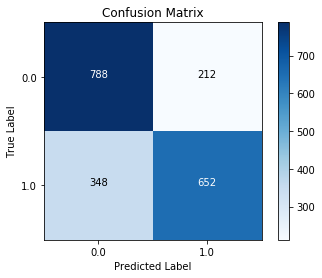

In [154]:
show_cf(test_labels, predictions)

In [155]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.69      0.79      0.74      1000
         1.0       0.75      0.65      0.70      1000

   micro avg       0.72      0.72      0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



For this problem we would like our model to limit the amount of False Positives (predicing 1=safe when the area is actually 0=danger).  This is because these types of errors much more costly compared to a model predicting dangerous areas when they are in fact safe.  The initial baselinee CNN has fewer False Positives than False Negatives.

In [177]:
# Save model
#model.save('Baseline_CNN_10epochs.h5')

## Model iteration 2: using a pre-trained model

We will now use feature extraction with a pre-trained CNN by taking the convolutional base of a pretrained network, and runing our satellite images through it. Then we will train a new classifier on top of the outputs.

In [158]:
# Use VGG19 for pre-trained model
cnn_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

In [159]:
# VGG19 summary
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [6]:
# Function for extracting features from VGG19 model
# Less expensive then training a DNN on top of frozen pre-trained model
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 10

def extract_features(directory, sample_amount, base_model, target_dimension=64, base_output_shape=(2,2,512)):
    features = np.zeros(shape=(sample_amount, base_output_shape[0], base_output_shape[1], base_output_shape[2])) # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_amount))
    generator = datagen.flow_from_directory(
        directory, target_size=(target_dimension, target_dimension), 
        batch_size = batch_size, 
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

The cell below takes a long time to run!!

In [163]:
# Run above function on all the images to get outputs
# you should be able to divide sample_amount by batch_size!!
train_features_vgg, train_labels_vgg = extract_features(train_folder, 6000, cnn_base) 
val_features_vgg, val_labels_vgg = extract_features(val_folder, 2000, cnn_base)
test_features_vgg, test_labels_vgg = extract_features(test_folder, 2000, cnn_base)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [169]:
# reshape the features to put into dense layer
train_features_vgg = np.reshape(train_features_vgg, (6000, 2 * 2 * 512))
val_features_vgg = np.reshape(val_features_vgg, (2000, 2 * 2 * 512))
test_features_vgg = np.reshape(test_features_vgg, (2000, 2 * 2 * 512))

In [171]:
# Use outputs from pretrained model and train on new densely connected classifier
model_vgg = models.Sequential()
model_vgg.add(layers.Dense(256, activation='relu', input_dim=2 * 2 * 512))
model_vgg.add(layers.Dense(1, activation='sigmoid'))

model_vgg.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history_vgg = model_vgg.fit(train_features_vgg, train_labels_vgg,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_features_vgg, val_labels_vgg))

Train on 6000 samples, validate on 2000 samples
Epoch 1/20
6000/6000 [==============================] - 7s 1ms/step - loss: 0.5699 - acc: 0.6993 - val_loss: 0.5430 - val_acc: 0.7055
Epoch 2/20
6000/6000 [==============================] - 6s 976us/step - loss: 0.5258 - acc: 0.7262 - val_loss: 0.5471 - val_acc: 0.7260
Epoch 3/20
6000/6000 [==============================] - 6s 995us/step - loss: 0.5118 - acc: 0.7365 - val_loss: 0.5269 - val_acc: 0.7155
Epoch 4/20
6000/6000 [==============================] - 6s 980us/step - loss: 0.5026 - acc: 0.7457 - val_loss: 0.5092 - val_acc: 0.7450
Epoch 5/20
6000/6000 [==============================] - 6s 994us/step - loss: 0.4966 - acc: 0.7433 - val_loss: 0.5094 - val_acc: 0.7435
Epoch 6/20
6000/6000 [==============================] - 6s 991us/step - loss: 0.4890 - acc: 0.7520 - val_loss: 0.5067 - val_acc: 0.7440
Epoch 7/20
6000/6000 [==============================] - 6s 1ms/step - loss: 0.4815 - acc: 0.7608 - val_loss: 0.5178 - val_acc: 0.7240
Epoc

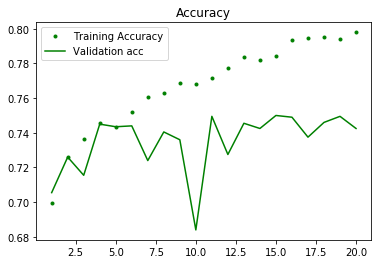

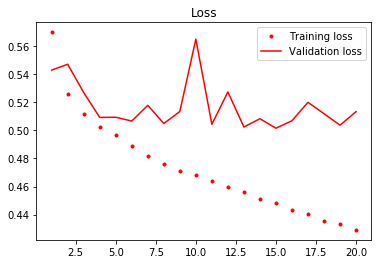

In [172]:
train_acc = history_vgg.history['acc']
val_acc = history_vgg.history['val_acc']
train_loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

In [173]:
results_test_vgg = model_vgg.evaluate(test_features_vgg, test_labels_vgg)
results_test_vgg

2000/2000 [==============================] - 1s 256us/step


[0.5167910249233246, 0.7445]

Accuracy using the pretrained model improves, although using pre-trained model and more epochs.

In [174]:
predictions_vgg = model_vgg.predict(test_features_vgg)
predictions_vgg = np.round(predictions_vgg)

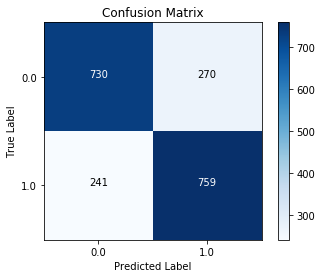

In [175]:
show_cf(test_labels_vgg, predictions_vgg)

In [176]:
print(classification_report(test_labels_vgg, predictions_vgg))

              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74      1000
         1.0       0.74      0.76      0.75      1000

   micro avg       0.74      0.74      0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



Granted the slight increase in all metrics, the pre-trained model does have more False Positives then the baseline CNN.

In [178]:
# Save model
#model_vgg.save('pre_trained_vgg19_20epochs.h5')

## Model iteration 3: ResNet and larger input sizes

This model will use the pre-trained ResNet50 model, which has been used successfully in other CNNs for satellite imagery (e.g. [here](https://www.researchgate.net/publication/331557018_Convolutional_Neural_Network_for_Satellite_Image_Classification) where ResNet50 achieved a better accuracy than AlexNet, VGG19 and GoogLeNet, and [here](https://medium.com/data-from-the-trenches/object-detection-with-deep-learning-on-aerial-imagery-2465078db8a9)).

It will also use a larger image size. The minimum for ResNet50 is 197x197, so 200x200 will be used.

In [5]:
 # get all the data in the directory model2_split/train (6000 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(200, 200), batch_size=6000, class_mode='binary')

 # get all the data in the directory model2_split/val (2000 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(200, 200), batch_size=2000, class_mode='binary')

# get all the data in the directory model2_split/test (2000 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(200, 200), batch_size = 2000, class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
# create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [7]:
# Use ResNet50 for pre-trained model
cnn_base_resnet = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(200, 200, 3))

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
cnn_base_resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
start = datetime.datetime.now()

train_features_resnet, train_labels_resnet = extract_features(train_folder, sample_amount=6000, base_model=cnn_base_resnet, target_dimension=200, base_output_shape=(7,7,2048))
val_features_resnet, val_labels_resnet = extract_features(val_folder, sample_amount=2000, base_model=cnn_base_resnet, target_dimension=200, base_output_shape=(7,7,2048))
test_features_resnet, test_labels_resnet = extract_features(test_folder, sample_amount=2000, base_model=cnn_base_resnet, target_dimension=200, base_output_shape=(7,7,2048))

end = datetime.datetime.now()
print("Time taken to run:", end-start)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Time taken to run: 2:19:41.955299


In [10]:
# reshape the features to put into dense layer
train_features_resnet = np.reshape(train_features_resnet, (6000, 7 * 7 * 2048))
val_features_resnet = np.reshape(val_features_resnet, (2000, 7 * 7 * 2048))
test_features_resnet = np.reshape(test_features_resnet, (2000, 7 * 7 * 2048))

In [11]:
# Use outputs from pretrained model and train on new densely connected classifier
start = datetime.datetime.now()

model_resnet = models.Sequential()
model_resnet.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 2048))
model_resnet.add(layers.Dense(1, activation='sigmoid'))

model_resnet.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history_resnet = model_resnet.fit(train_features_resnet, train_labels_resnet,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_features_resnet, val_labels_resnet))

end = datetime.datetime.now()
print("Time taken to run:", end-start)

Train on 6000 samples, validate on 2000 samples
Epoch 1/20
6000/6000 [==============================] - 83s 14ms/step - loss: 8.0148 - acc: 0.5007 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/20
6000/6000 [==============================] - 70s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/20
6000/6000 [==============================] - 68s 11ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/20
6000/6000 [==============================] - 67s 11ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/20
6000/6000 [==============================] - 69s 11ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/20
6000/6000 [==============================] - 66s 11ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/20
6000/6000 [==============================] - 68s 11ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


In [14]:
def cnn_evaluation(model, history, test_features, test_labels, class_names=None, model_name=None):
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epch = range(1, len(train_acc) + 1)
    plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
    plt.plot(epch, val_acc, 'g', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epch, train_loss, 'r.', label='Training loss')
    plt.plot(epch, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    results_test = model.evaluate(test_features, test_labels)
    print('Test Loss:', results_test[0])
    print('Test Accuracy:', results_test[1])
    
    y_pred = np.round(model.predict(test_features))
    
    show_cf(test_labels, y_pred, class_names=class_names, model_name=model_name)
    
    print(classification_report(test_labels, y_pred))

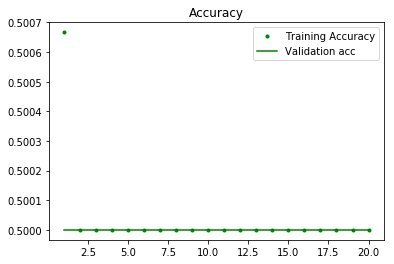

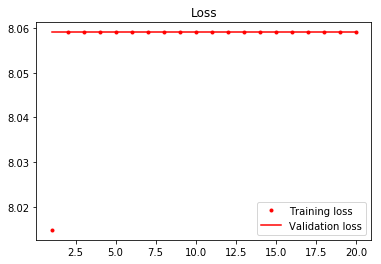

2000/2000 [==============================] - 3s 2ms/step
Test Loss: 8.059047821044922
Test Accuracy: 0.5
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      1000
         1.0       0.00      0.00      0.00      1000

   micro avg       0.50      0.50      0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


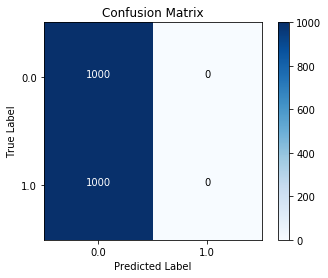

In [34]:
cnn_evaluation(model_resnet, history_resnet, test_features_resnet, test_labels_resnet)

## Model iteration 4: VGG19 pre-trained model with larger inputs, regularization and more layers

In [5]:
# get all the data in the directory model2_split/train (6000 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(200, 200), batch_size=6000, class_mode='binary')

 # get all the data in the directory model2_split/val (2000 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(200, 200), batch_size=2000, class_mode='binary')

# get all the data in the directory model2_split/test (2000 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(200, 200), batch_size = 2000, class_mode='binary')

# create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

# Use VGG19 for pre-trained model
cnn_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(200, 200, 3))

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
start = datetime.datetime.now()

datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 10

# Extracting features
train_features_vgg, train_labels_vgg = extract_features(train_folder, sample_amount=6000, base_model=cnn_base, target_dimension=200, base_output_shape=(6,6,512))
val_features_vgg, val_labels_vgg = extract_features(val_folder, sample_amount=2000, base_model=cnn_base, target_dimension=200, base_output_shape=(6,6,512))
test_features_vgg, test_labels_vgg = extract_features(test_folder, sample_amount=2000, base_model=cnn_base, target_dimension=200, base_output_shape=(6,6,512))

end = datetime.datetime.now()
print("Time taken to run:", end-start)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Time taken to run: 1:30:06.295934


In [11]:
start = datetime.datetime.now()

# reshape the features to put into dense layer
train_features_vgg = np.reshape(train_features_vgg, (6000, 6 * 6 * 512))
val_features_vgg = np.reshape(val_features_vgg, (2000, 6 * 6 * 512))
test_features_vgg = np.reshape(test_features_vgg, (2000, 6 * 6 * 512))

# Use outputs from pretrained model and train on new densely connected classifier
model_vgg2 = models.Sequential()
model_vgg2.add(layers.Dense(128, activation='relu', input_dim=6 * 6 * 512, kernel_regularizer=regularizers.l1(0.005)))
model_vgg2.add(layers.Dense(256, activation='relu', input_dim=6 * 6 * 512, kernel_regularizer=regularizers.l1(0.005)))
model_vgg2.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.005)))

model_vgg2.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history_vgg2 = model_vgg2.fit(train_features_vgg, train_labels_vgg,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_features_vgg, val_labels_vgg))

end = datetime.datetime.now()
print("Time taken to run:", end-start)

Train on 6000 samples, validate on 2000 samples
Epoch 1/20
6000/6000 [==============================] - 11s 2ms/step - loss: 40.4965 - acc: 0.6863 - val_loss: 9.3919 - val_acc: 0.6820
Epoch 2/20
6000/6000 [==============================] - 9s 2ms/step - loss: 7.9185 - acc: 0.7042 - val_loss: 6.7801 - val_acc: 0.6500
Epoch 3/20
6000/6000 [==============================] - 9s 2ms/step - loss: 5.6860 - acc: 0.7073 - val_loss: 4.7770 - val_acc: 0.6810
Epoch 4/20
6000/6000 [==============================] - 11s 2ms/step - loss: 3.9852 - acc: 0.7135 - val_loss: 3.3240 - val_acc: 0.6105
Epoch 5/20
6000/6000 [==============================] - 11s 2ms/step - loss: 2.7183 - acc: 0.7160 - val_loss: 2.3064 - val_acc: 0.5855
Epoch 6/20
6000/6000 [==============================] - 10s 2ms/step - loss: 1.8935 - acc: 0.7225 - val_loss: 1.6949 - val_acc: 0.6260
Epoch 7/20
6000/6000 [==============================] - 10s 2ms/step - loss: 1.5112 - acc: 0.7245 - val_loss: 1.4934 - val_acc: 0.6800
Epoch 8/

In [12]:
model_vgg2.save('pre_trained_vgg19_v2_20epochs.h5')

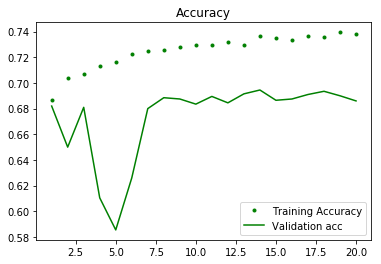

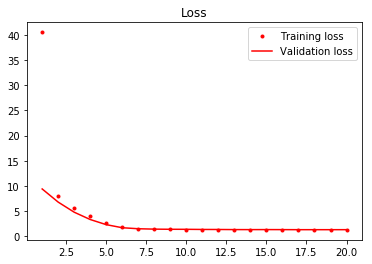

2000/2000 [==============================] - 1s 417us/step
Test Loss: 1.2130945119857788
Test Accuracy: 0.789
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80      1000
         1.0       0.83      0.73      0.78      1000

   micro avg       0.79      0.79      0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



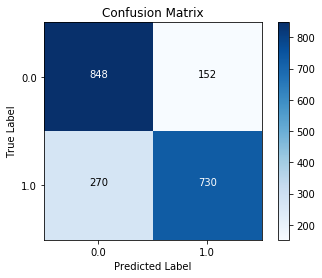

In [17]:
cnn_evaluation(model_vgg2, history_vgg2, test_features_vgg, test_labels_vgg)

This model performs better (F1 score of 0.79 vs 0.74), although there is still some overfitting. The model's main issue is with incorrectly predicting safe squares as danger squares, but this is preferable to the other way around.

## Possible Changes
- use different size instead of (64x64)
- use different pre-trained model
- use freezing and finetuning (would need to be on cloud, possibly for model 3?)
- change architecture of new densely connected classifier on top of pre-trained model
- change architechure for baseline CNN